# Finetune SAM

## 1. import package

In [1]:
import os
os.chdir('/root/xyf/semantic segmentation MMseg/mmsegmentation')
os.getcwd()

'/root/xyf/semantic segmentation MMseg/mmsegmentation'

## 2. load SAM

In [2]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
0
NVIDIA A10


In [3]:
from segment_anything import sam_model_registry, SamPredictor

#sam_checkpoint = "/root/ossfs/westlake/code/sam/checkpoints/sam_vit_h_4b8939.pth"
sam_checkpoint = "/root/xyf/semantic segmentation MMseg/lightning/out/training/epoch-000002-f10.16-ckpt.pth"
sam_checkpointor = "/root/xyf/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

In [4]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint) #checkpoint=
sam.to(device=device)

predictor = SamPredictor(sam)

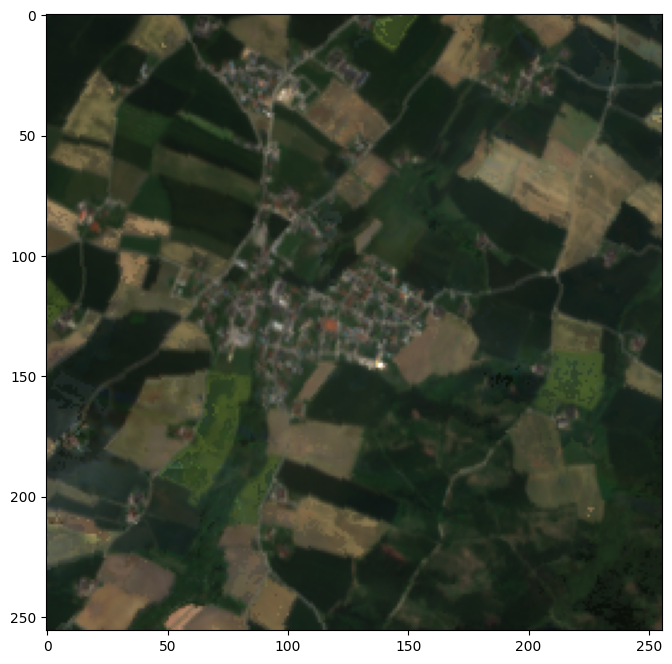

In [5]:
#visualize the image
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img_path = '/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/images/validation/AT_6336_S2_10m_256.tif'
img_bgr = cv2.imread(img_path)
plt.figure(figsize=(8, 8))
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 3. predict logits with deeplabv3

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv

NOTE! Installing ujson may make loading annotations faster.


In [7]:
#model config file
config_file = '/root/xyf/semantic segmentation MMseg/mmsegmentation/work_dirs/deeplabv3_r50-d8_4xb4-80k_AI4b-256x256/deeplabv3_r50-d8_4xb4-80k_AI4b-256x256.py'

#model checkpoint file
checkpoint_file = '/root/xyf/semantic segmentation MMseg/mmsegmentation/work_dirs/deeplabv3_r50-d8_4xb4-80k_AI4b-256x256/iter_80000.pth'

device = 'cuda:0'
model = init_model(config_file, checkpoint_file, device='cpu')

/root/xyf/semantic segmentation MMseg/mmsegmentation/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'


Loads checkpoint by local backend from path: /root/xyf/semantic segmentation MMseg/mmsegmentation/work_dirs/deeplabv3_r50-d8_4xb4-80k_AI4b-256x256/iter_80000.pth


In [8]:
# 推理给定图像
img_path1 = "/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/images/validation/AT_6336_S2_10m_256.tif"
result1 = inference_model(model, img_path)

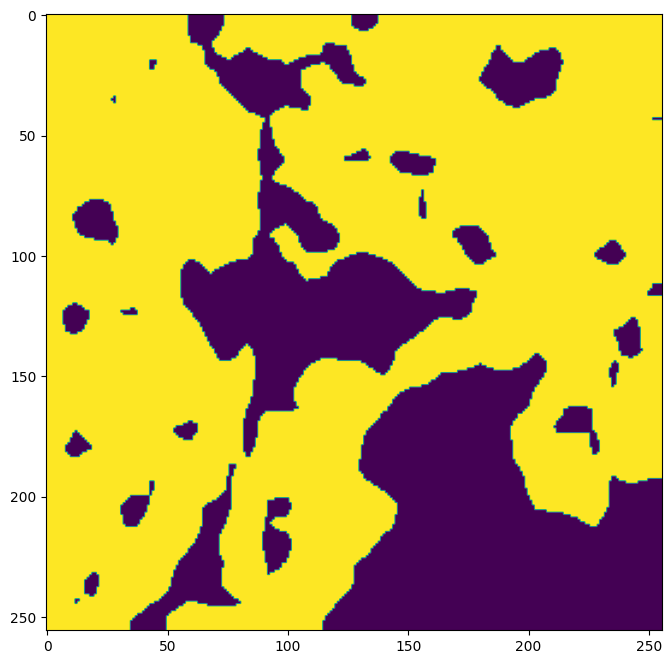

In [9]:
a = result1.pred_sem_seg.data.numpy()
plt.figure(figsize=(8, 8))
plt.imshow(a[0,:,:])
plt.show()

In [10]:
logits = result1.seg_logits.data[None,1,:,:]
mask = logits[None,0,:,:]
#mask

## 4. check the SAM prompt encoder

In [11]:
mask_input_torch = torch.as_tensor(logits, dtype=torch.float, device=device)
mask_input_torch = mask_input_torch[None, :, :, :]
mask_input_torch

tensor([[[[1.7677, 1.7677, 1.7677,  ..., 1.4585, 1.4585, 1.4585],
          [1.7677, 1.7677, 1.7677,  ..., 1.4585, 1.4585, 1.4585],
          [1.7677, 1.7677, 1.7677,  ..., 1.4585, 1.4585, 1.4585],
          ...,
          [0.3624, 0.3624, 0.3624,  ..., 0.2551, 0.2551, 0.2551],
          [0.3624, 0.3624, 0.3624,  ..., 0.2551, 0.2551, 0.2551],
          [0.3624, 0.3624, 0.3624,  ..., 0.2551, 0.2551, 0.2551]]]],
       device='cuda:0')

In [60]:
with torch.no_grad():
    sparse_embeddings, dense_embeddings = predictor.model.prompt_encoder(
                points=None,
                boxes=None,
                masks=mask_input_torch
            )

In [16]:
dense_embeddings.shape[:]

torch.Size([1, 256, 64, 64])

In [29]:
point_coords = np.array([[20, 20]])
point_labels = np.array([1])

point_coords = predictor.transform.apply_coords(point_coords, [256,256])
coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=device)
labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=device)
coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]
points = (coords_torch, labels_torch)

with torch.no_grad():
    sparse_embeddings1, dense_embeddings1 = predictor.model.prompt_encoder(
                points=points,
                boxes=None,
                masks=None
            )

In [20]:
predictor.set_image(img_bgr)
input_point = np.array([[20, 20]])
input_label = np.array([1])
masks, _, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    mask_input=mask,
    multimask_output=False,
)
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]]])

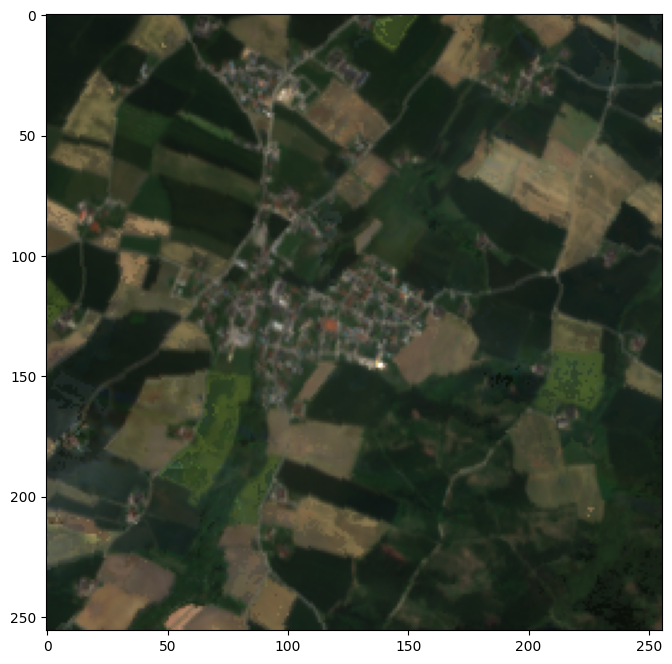

In [12]:
plt.figure(figsize=(8, 8))
plt.imshow(img_bgr[:,:,::-1])
plt.show()

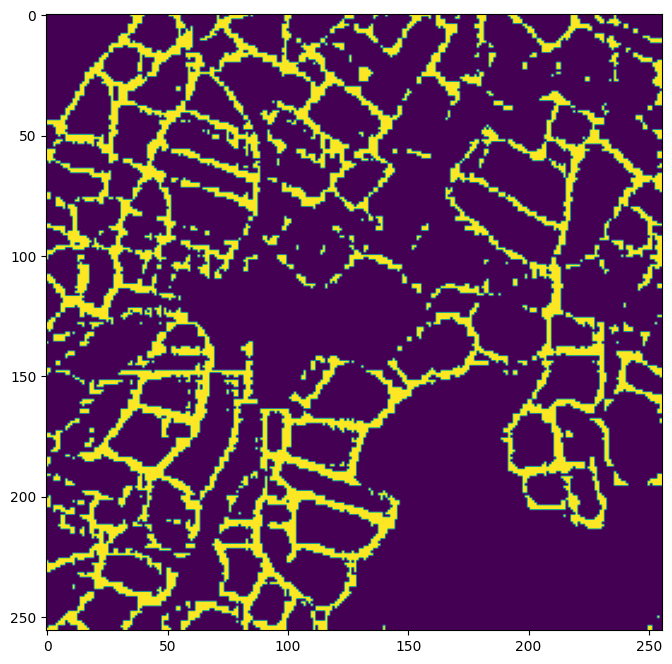

In [12]:
plt.figure(figsize=(8, 8))
plt.imshow(masks[0,:,:])
plt.show()

In [13]:
from osgeo import gdal
label = "/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/annotations/validation/AT_6336_S2_10m_256.tif"
gt_gadl = gdal.Open(label)
gt_gadl = gt_gadl.ReadAsArray(band_list=[2])
gt_gadl

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

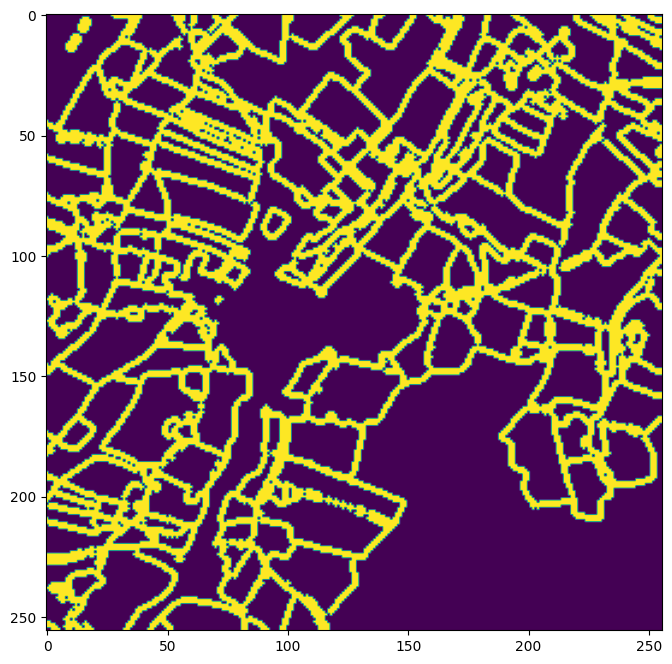

In [14]:
plt.figure(figsize=(8, 8))
plt.imshow(gt_gadl)
plt.show()

In [9]:
sum(sum(gt_gadl==False))

43794

In [16]:
premask = result1.pred_sem_seg.data.numpy().astype(np.byte)
premask.shape

(1, 256, 256)

In [17]:
import numpy as np

def calculate_accuracy(image1, image2):
    # 检查图像大小是否一致
    if image1.shape != image2.shape:
        raise ValueError("The shapes of the two images do not match.")
    
    # 计算相等的像素数量
    equal_pixels = np.sum(image1 == image2)
    
    # 总像素数量
    total_pixels = image1.size
    
    # 计算准确率
    accuracy = equal_pixels / total_pixels
    
    return accuracy

# 示例

accuracy = calculate_accuracy(premask[0,:,:], gt_gadl)
accuracy_2 = calculate_accuracy(masks[0,:,:], gt_gadl)
print("Accuracy:", accuracy)
print("Accuracy2:", accuracy_2)


Accuracy: 0.4970550537109375
Accuracy2: 0.7769012451171875


# 5. finetune SAM

In [33]:
#define the adam optimizer
optimizer = torch.optim.Adam(sam.mask_decoder.parameters())

#define loss function
loss_fn = torch.nn.MSELoss()

In [ ]:
#image encoder
with torch.no_grad():
    image_embaddeing = sam.image_encoder(input_image)

#prompt encoder
with torch.no_grad():
    sparse_embeddings, dense_embeddings = sam.prompt_encoder(
        points=None,
        boxes=None,
        masks=mask_input_torch,)
    
#finetune mask decoder

low_res_masks, iou_predictions = sam.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,)

#upscaling the mask
#upscaled_masks = sam.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)

from torch.nn.functional import threshold, normalize

binary_mask = normalize(threshold(low_res_masks, 0.0, 0)).to(device)

#calculate loss function
loss = loss_fn(binary_mask, gt_binary_mask)
optimizer.zero_grad()
loss.backward()
optimizer.step()


# Finetune with lighting package

### Try 1: Finetune SAM with the extent mask

#### Result:
Validation [0]: Mean IoU: [0.4898] -- Mean F1: [0.6073] -- Mean accuracy[0.8362] -- Mean precision: [0.7485]

loss function:
    loss_total = 20. * loss_focal + loss_dice + loss_iou

config = {
    "num_devices": 1,
    'batch_size': 2,
    "num_workers": 4,
    "num_epochs": 20,
    "eval_interval": 10,
    "out_dir": "/root/xyf/semantic segmentation MMseg/lightning/out/training",
    "opt":{
        "learning_rate": 8e-4,
        "weight_decay": 1e-4,
        "decay_factor": 10,
        "steps": [60000, 86666],
        "warmup_steps":250,
    },
    "sam":{
        "type": 'vit_h',
        "checkpoint": "/root/xyf/sam_vit_h_4b8939.pth",
        "freeze":{
            "image_encoder": True,
            "prompt_encoder": True,
            "mask_decoder": False
        },
    },
    "deeplab":{
        "type": "Deeplabv3",
        "checkpoint": '/root/xyf/semantic segmentation MMseg/mmsegmentation/work_dirs/deeplabv3_r50-d8_4xb4-80k_AI4b-256x256/iter_80000.pth',
        "config_path": '/root/xyf/semantic segmentation MMseg/mmsegmentation/work_dirs/deeplabv3_r50-d8_4xb4-80k_AI4b-256x256/deeplabv3_r50-d8_4xb4-80k_AI4b-256x256.py',
        "freeze":{
            "backbone": True,
            "decode_head": True,
            "auxiliary_head": True
        }
    },
    "dataset":{
        "images": {
            "training": "/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/images/training",
            "validation": "/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/images/validation"
        },
        "annotations":{
            "training":"/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/annotations/training",
            "validation": "/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/annotations/validation"
        },
        "premasks":{
            "training": "/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/premasks/training",
            "validation": "/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/premasks/validation"
        }
    }
}

### Try 2: Finetune SAM with the boundary mask

#### Result:
Validation [0]: Mean IoU: [0.1535] -- Mean F1: [0.2325] -- Mean accuracy[0.8777] -- Mean precision: [0.5846]

config = {
    "num_devices": 1,
    'batch_size': 2,
    "num_workers": 4,
    "num_epochs": 20,
    "eval_interval": 10,
    "out_dir": "/root/xyf/semantic segmentation MMseg/lightning/out/training",
    "opt":{
        "learning_rate": 8e-4,
        "weight_decay": 1e-4,
        "decay_factor": 10,
        "steps": [60000, 86666],
        "warmup_steps":250,
    },
    "sam":{
        "type": 'vit_h',
        "checkpoint": "/root/xyf/sam_vit_h_4b8939.pth",
        "freeze":{
            "image_encoder": True,
            "prompt_encoder": True,
            "mask_decoder": False
        },
    },
    "deeplab":{
        "type": "Deeplabv3",
        "checkpoint": '/root/xyf/semantic segmentation MMseg/mmsegmentation/work_dirs/deeplabv3_r50-d8_4xb4-80k_AI4b-256x256/iter_80000.pth',
        "config_path": '/root/xyf/semantic segmentation MMseg/mmsegmentation/work_dirs/deeplabv3_r50-d8_4xb4-80k_AI4b-256x256/deeplabv3_r50-d8_4xb4-80k_AI4b-256x256.py',
        "freeze":{
            "backbone": True,
            "decode_head": True,
            "auxiliary_head": True
        }
    },
    "dataset":{
        "images": {
            "training": "/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/images/training",
            "validation": "/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/images/validation"
        },
        "annotations":{
            "training":"/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/annotations/training",
            "validation": "/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/annotations/validation"
        },
        "premasks":{
            "training": "/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/premasks/training",
            "validation": "/root/xyf/semantic segmentation MMseg/mmsegmentation/AI4B_data/AI4boundaries_dataset/AI4B_preprocessed/premasks/validation"
        }
    }
}

## Postprocess

In [ ]:
mask01 = masks[0,:,:].astype("uint8")

In [ ]:
kernel = np.ones((2,2),np.uint8) 
erosion_1 = cv2.erode(mask01,kernel,iterations = 1)
erosion_2 = cv2.erode(mask01,kernel,iterations = 2)
erosion_3 = cv2.erode(mask01,kernel,iterations = 3)


In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(erosion_2)
plt.show()

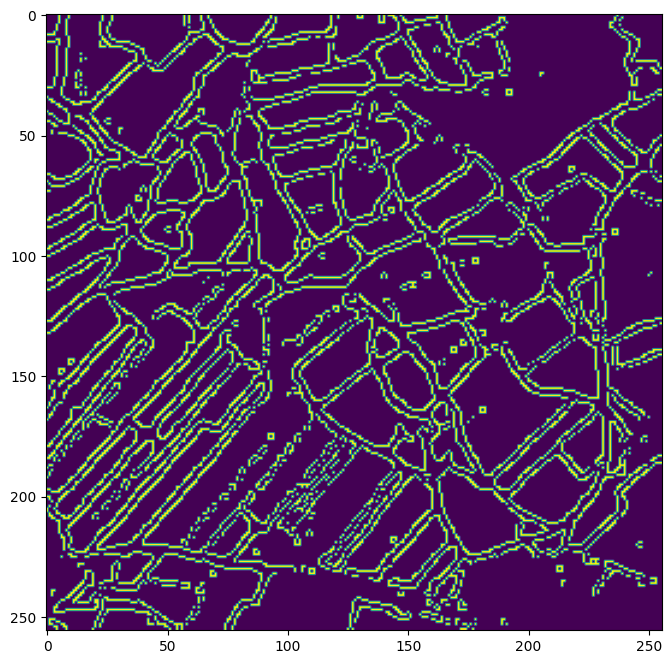

In [67]:
can = cv2.Canny(mask01,0,1)
plt.figure(figsize=(8, 8))
plt.imshow(can)
plt.show()

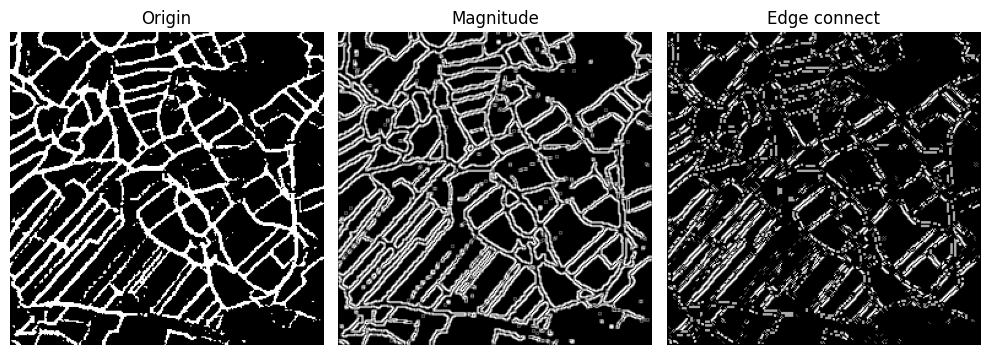

In [68]:
    # 11.9 边缘连接的局部处理方法
    img = mask01
    # img16 = np.array(img, dtype='uint16')
    hImg, wImg = img.shape#[0], img.shape[1]

    # Sobel 梯度算子
    kSobelX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kSobelY = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    gx = cv2.filter2D(img, cv2.CV_64F, kSobelX)  # SobelX 水平梯度
    gy = cv2.filter2D(img, cv2.CV_64F, kSobelY)  # SobelY 垂直梯度

    # 计算梯度向量的幅值 mag 与角度 angle
    # magn = np.sqrt(np.power(gx,2) + np.power(gy,2))  # 梯度向量的幅值
    magn = cv2.normalize(abs(gx)+abs(gy), None, 0, 255, cv2.NORM_MINMAX)  # 用绝对值近似梯度幅值
    gxFlat, gyFlat = gx.flatten(), gy.flatten()  # 展平为一维，便于计算角度
    angleFlat = np.arctan2(gy, gx) * 180 / np.pi  # 梯度向量的角度，将弧度转为角度: (-180, 180)
    angle = angleFlat.reshape(hImg, wImg)

    # 边缘像素相似性判断
    edge = np.zeros((hImg,wImg), np.uint8)
    for h in range(1, hImg-1):  # 对边界点不判断
        for w in range(1, wImg-1):
            if (abs(magn[h,w]-magn[h-1,w-1])<=30) and (abs(angle[h,w]-angle[h-1,w-1])<=15)\
            or (abs(magn[h,w]-magn[h-1,w+1])<=30) and (abs(angle[h,w]-angle[h-1,w+1])<=15)\
            or (abs(magn[h,w]-magn[h+1,w-1])<=30) and (abs(angle[h,w]-angle[h+1,w-1])<=15)\
            or (abs(magn[h,w]-magn[h+1,w+1])<=30) and (abs(angle[h,w]-angle[h+1,w+1])<=15):
                edge[h,w] = magn[h,w]

    plt.figure(figsize=(10, 5))
    plt.subplot(131), plt.title("Origin"), plt.imshow(img, cmap='gray'), plt.axis('off')
    plt.subplot(132), plt.title("Magnitude"), plt.imshow(np.uint8(magn), cmap='gray'), plt.axis('off')
    # plt.subplot(133), plt.title("angle"), plt.imshow(np.uint8(angle), cmap='gray'), plt.axis('off')
    plt.subplot(133), plt.title("Edge connect"), plt.imshow(np.uint8(edge), cmap='gray'), plt.axis('off')
    plt.tight_layout()
    plt.show()


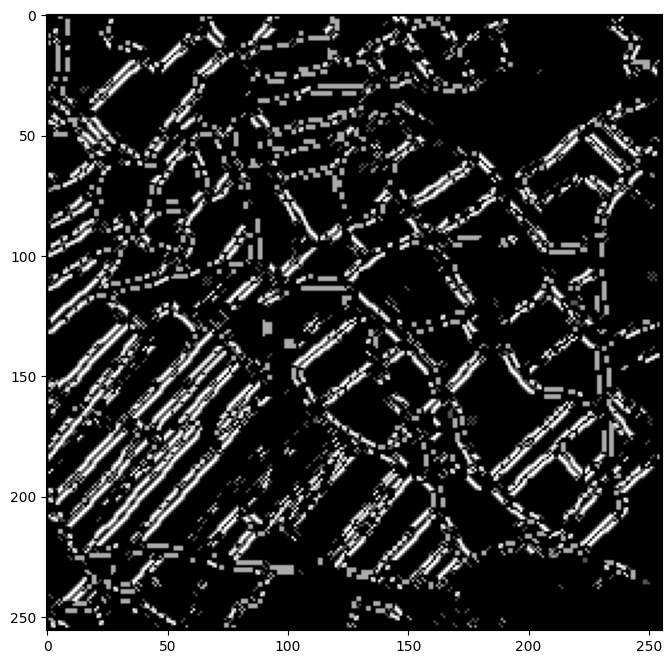

In [70]:
plt.figure(figsize=(8, 8))
plt.imshow(np.uint8(edge), cmap='gray')

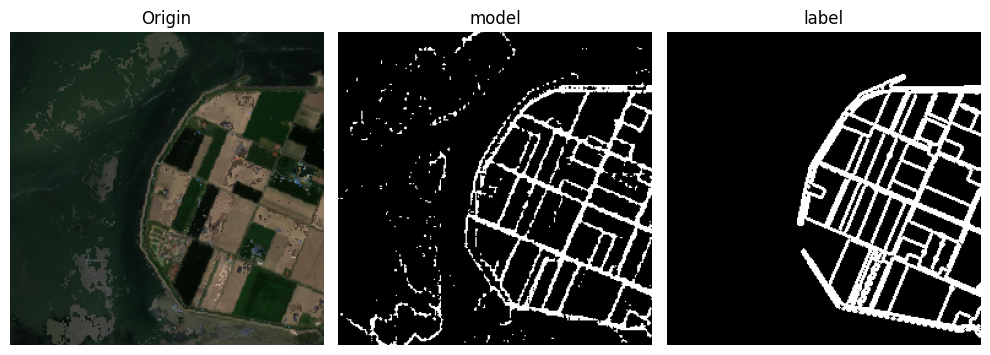

In [88]:
#closing1 = cv2.morphologyEx(mask01,cv2.MORPH_OPEN,kernel=(4,4),iterations=1)

plt.figure(figsize=(10, 5))
plt.subplot(131), plt.title("Origin"), plt.imshow(img_bgr[:,:,::-1]), plt.axis('off')
plt.subplot(132), plt.title("model"), plt.imshow(masks[0,:,:], cmap='gray'), plt.axis('off')
plt.subplot(133), plt.title("label"), plt.imshow(np.uint8(gt_gadl), cmap='gray'), plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
"""
refer to https://github.com/jfzhang95/pytorch-deeplab-xception/blob/master/utils/metrics.py
"""

import numpy as np
__all__ = ['SegmentationMetric']
 
"""
confusionMetric  # 注意：此处横着代表预测值，竖着代表真实值，与之前介绍的相反
P\L     P    N
P      TP    FP
N      FN    TN
"""
class SegmentationMetric(object):
    def __init__(self, numClass):
        self.numClass = numClass
        self.confusionMatrix = np.zeros((self.numClass,)*2)
 
    def pixelAccuracy(self):
        # return all class overall pixel accuracy
        #  PA = acc = (TP + TN) / (TP + TN + FP + TN)
        acc = np.diag(self.confusionMatrix).sum() /  self.confusionMatrix.sum()
        return acc
 
    def classPixelAccuracy(self):
        # return each category pixel accuracy(A more accurate way to call it precision)
        # acc = (TP) / TP + FP
        classAcc = np.diag(self.confusionMatrix) / self.confusionMatrix.sum(axis=1)
        return classAcc # 返回的是一个列表值，如：[0.90, 0.80, 0.96]，表示类别1 2 3各类别的预测准确率
 
    def meanPixelAccuracy(self):
        classAcc = self.classPixelAccuracy()
        meanAcc = np.nanmean(classAcc) # np.nanmean 求平均值，nan表示遇到Nan类型，其值取为0
        return meanAcc # 返回单个值，如：np.nanmean([0.90, 0.80, 0.96, nan, nan]) = (0.90 + 0.80 + 0.96） / 3 =  0.89
 
    def meanIntersectionOverUnion(self):
        # Intersection = TP Union = TP + FP + FN
        # IoU = TP / (TP + FP + FN)
        intersection = np.diag(self.confusionMatrix) # 取对角元素的值，返回列表
        union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(self.confusionMatrix) # axis = 1表示混淆矩阵行的值，返回列表； axis = 0表示取混淆矩阵列的值，返回列表 
        IoU = intersection / union  # 返回列表，其值为各个类别的IoU
        mIoU = np.nanmean(IoU) # 求各类别IoU的平均
        return mIoU
 
    def genConfusionMatrix(self, imgPredict, imgLabel): # 同FCN中score.py的fast_hist()函数
        # remove classes from unlabeled pixels in gt image and predict
        mask = (imgLabel >= 0) & (imgLabel < self.numClass)
        label = self.numClass * imgLabel[mask].astype(int) + imgPredict[mask]
        count = np.bincount(label, minlength=self.numClass**2)
        confusionMatrix = count.reshape(self.numClass, self.numClass)
        return confusionMatrix
 
    def Frequency_Weighted_Intersection_over_Union(self):
        # FWIOU =     [(TP+FN)/(TP+FP+TN+FN)] *[TP / (TP + FP + FN)]
        freq = np.sum(self.confusion_matrix, axis=1) / np.sum(self.confusion_matrix)
        iu = np.diag(self.confusion_matrix) / (
                np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                np.diag(self.confusion_matrix))
        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU
 
 
    def addBatch(self, imgPredict, imgLabel):
        assert imgPredict.shape == imgLabel.shape
        self.confusionMatrix += self.genConfusionMatrix(imgPredict, imgLabel)
 
    def reset(self):
        self.confusionMatrix = np.zeros((self.numClass, self.numClass))
 
 
if __name__ == '__main__':
    imgPredict = masks[0,:,:] # 可直接换成预测图片
    imgLabel = np.uint8(gt_gadl) # 可直接换成标注图片
    metric = SegmentationMetric(2) 
    metric.addBatch(imgPredict, imgLabel)
    confusion = metric.confusionMatrix
    pa = metric.pixelAccuracy()
    cpa = metric.classPixelAccuracy()
    mpa = metric.meanPixelAccuracy()
    mIoU = metric.meanIntersectionOverUnion()
    print('confusionMatrix is:')
    print(confusion)
    print('pa is : %f' % pa)
    print('cpa is :') # 列表
    print(cpa)
    print('mpa is : %f' % mpa)
    print('mIoU is : %f' % mIoU)

confusionMatrix is:
[[42383.  3439.]
 [11182.  8532.]]
pa is : 0.776901
cpa is :
[0.92494871 0.43278888]
mpa is : 0.678869
mIoU is : 0.556007


In [19]:
pre = masks[0,:,:]
label = np.uint8(gt_gadl)
temp = pre + 2*label
TP = sum(sum(temp==3))
TN = sum(sum(temp==0))
FP = sum(sum(temp==1))
FN = sum(sum(temp==2))
TP/(TP+FP+FN)

0.3685051613181877